# Stochastic Kinematically Informed Earthquake Sequences (SKIES)
1. Calculate kinematically informed random epicenter
     $$P(c(t)) = \frac{1}{1+e^{-c(t)}} + \mathrm{history}$$
     where $c(t)$ is the coupling rate at time ($t$).  This is an instantaneous formulation.  We could also do this with a more history dependent formulation.  This could include dropping probabilities after an event ruptures a triangular element much like a "state" effect.  This could sort of halo certain regions
2. Calculate random magnitude from Gutenberg-Richter distribution with a minimum magnitude based on minimum triangle area 
3. Calculate approximate rupture area, $a$ with empirical scaling law (Allen and Hayes, 2017)
4. Find subset of $n$ triangles with areas $a_n$ that sum to $a$ some factor
5. Calculate eigenfunctions for these triangles
6. Generate random Gaussian slip pattern from randomly weighted eigenvectors
7. Sigmoid scaling of slip with distance from the hypocenter so that it tapers to zero at rupture edge
8. Rescale random Gaussian slip pattern to get the magnitude correct

# This model is consistent with:
1. Gutenberg-Richter magnitude-frequency distribution
2. Utsu-Omori aftershock decay rate
3. Empirical moment magnitude to rupture area scaling laws (bi-linear Allen and Hayes, 2017)
4. Crack theory for rupture shape (circular small earthquakes)
5. Geometric fault limits on rupture width and shape
6. Estimated roughness of coseismic slip distributions
7. Earthquake slip is probabilistically focused on regions with accumulated slip deficits
8. Co-seismic and inter-seismic moment balance (can be adjusted for imbalance)
9. Geodetically constrained decadal-scale interseismic fault coupling

In [9]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import addict
import copy
import datetime
import json
import meshio
import os
import warnings
import scipy
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
from ismember import ismember
import matplotlib
import skies


FONTSIZE = 18

In [11]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)

output_path='./runs/2022_09_14_12_49_11'
Read: western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: cascadia.msh
Magnitude overview:
Maximum moment magnitude of entire mesh = 10.61
Maximum moment magnitude of single mesh element = 6.90
Minimum moment magnitude of single mesh element = 5.52
Maximum allowed moment magnitude = 9.50
Minimum allowed moment magnitude = 7.50
Maximum moment magnitude of entire mesh (10.61) exceeds MAXIMUM_EVENT_MOMENT_MAGNITUDE


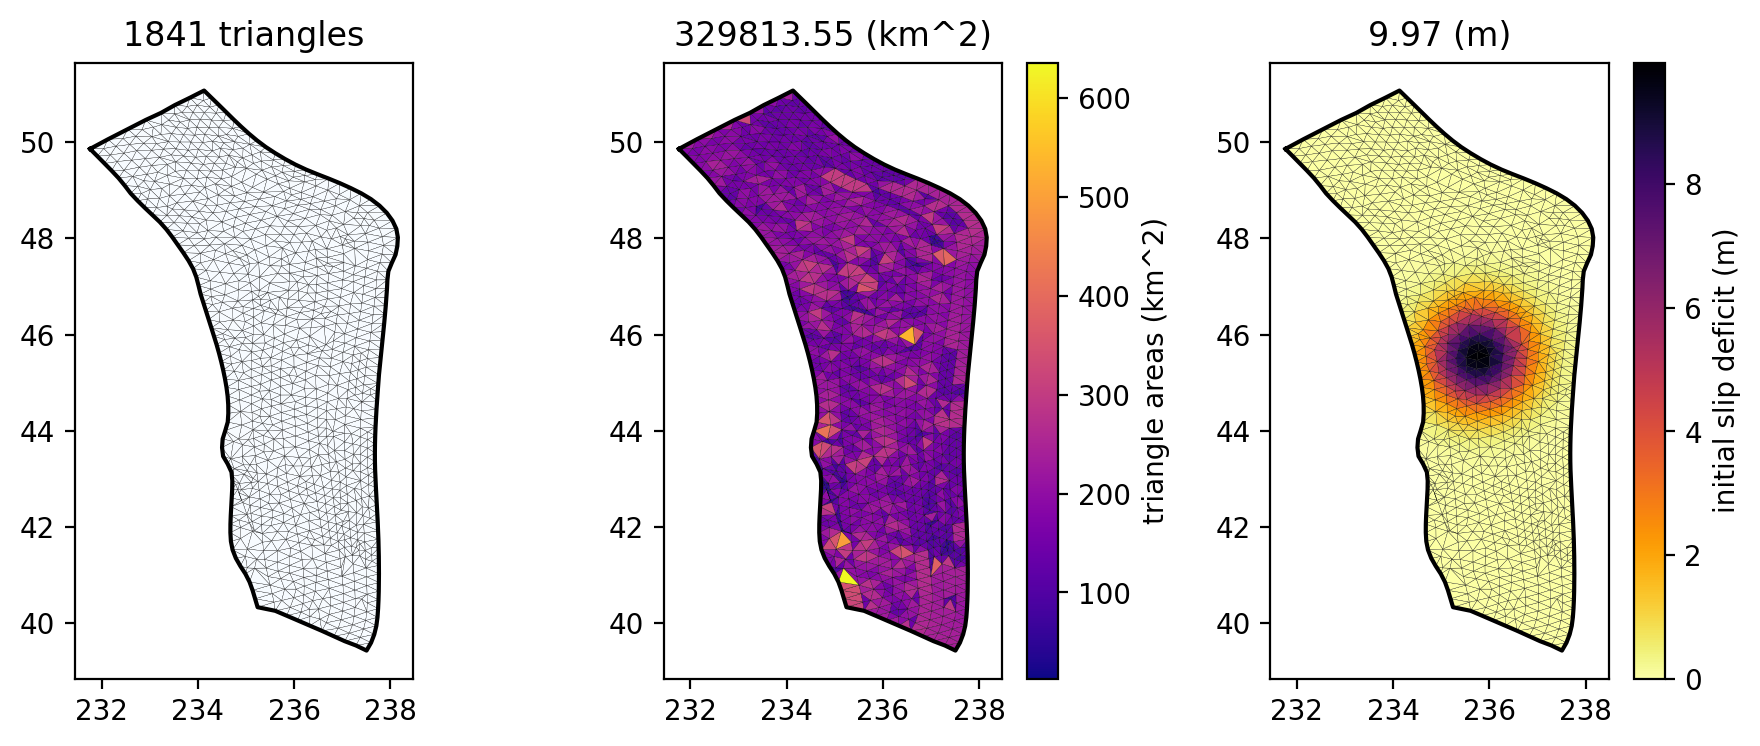

In [12]:
# Set initial conditions with accumulated slip
sources = addict.Dict()
sources.lon = np.array([235.779])
sources.lat = np.array([45.553])
sources.magnitude = np.array([10.0])
sources.slip_type = ["dip_slip"]
initial_slip_deficit = skies.get_synthetic_accumulated_slip(meshes[0], sources)
initial_dip_slip_deficit = initial_slip_deficit[1::2]
total_coseismic_slip = np.zeros_like(initial_dip_slip_deficit)
skies.plot_initial_data(meshes, initial_dip_slip_deficit)


i=0
np.sum(pre_event_slip_deficit > 0)=1841
np.sum(np.isnan(temp_slip_deficit))=0
np.sum(np.isnan(probability))=0


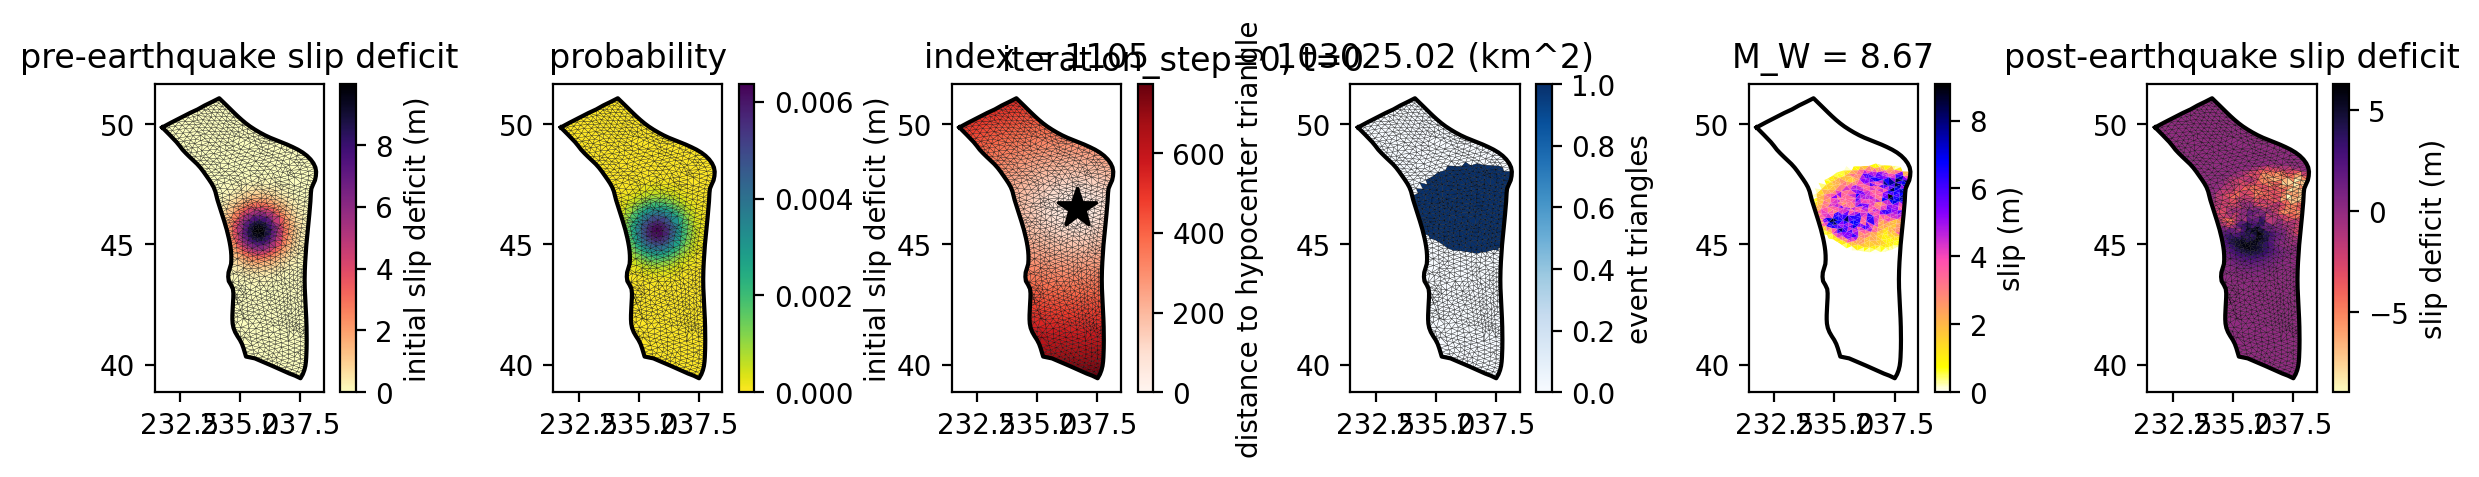

i=1
np.sum(pre_event_slip_deficit > 0)=1442
np.sum(np.isnan(temp_slip_deficit))=0
np.sum(np.isnan(probability))=0


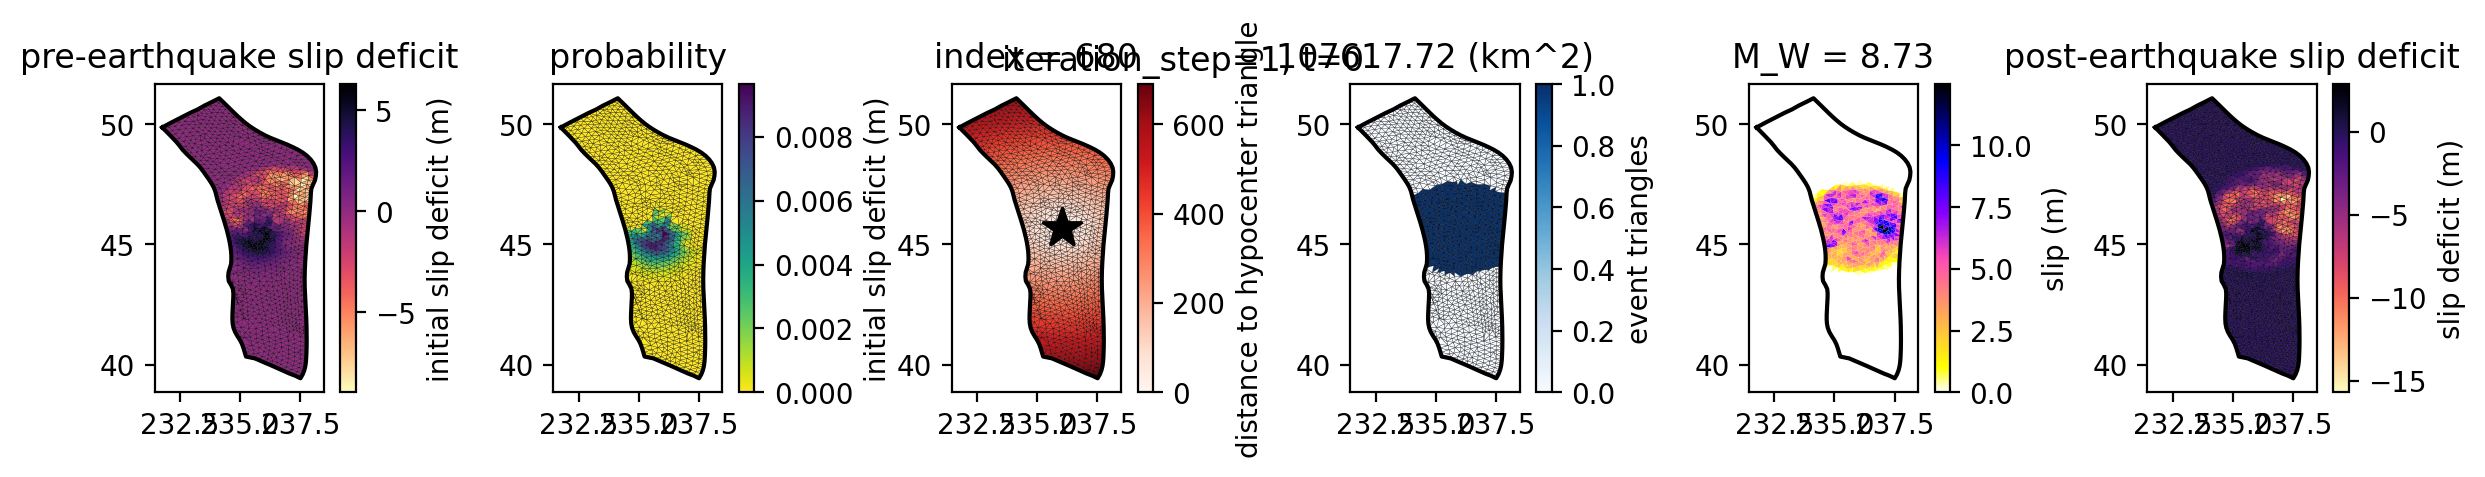

i=2
np.sum(pre_event_slip_deficit > 0)=1202
np.sum(np.isnan(temp_slip_deficit))=0
np.sum(np.isnan(probability))=0


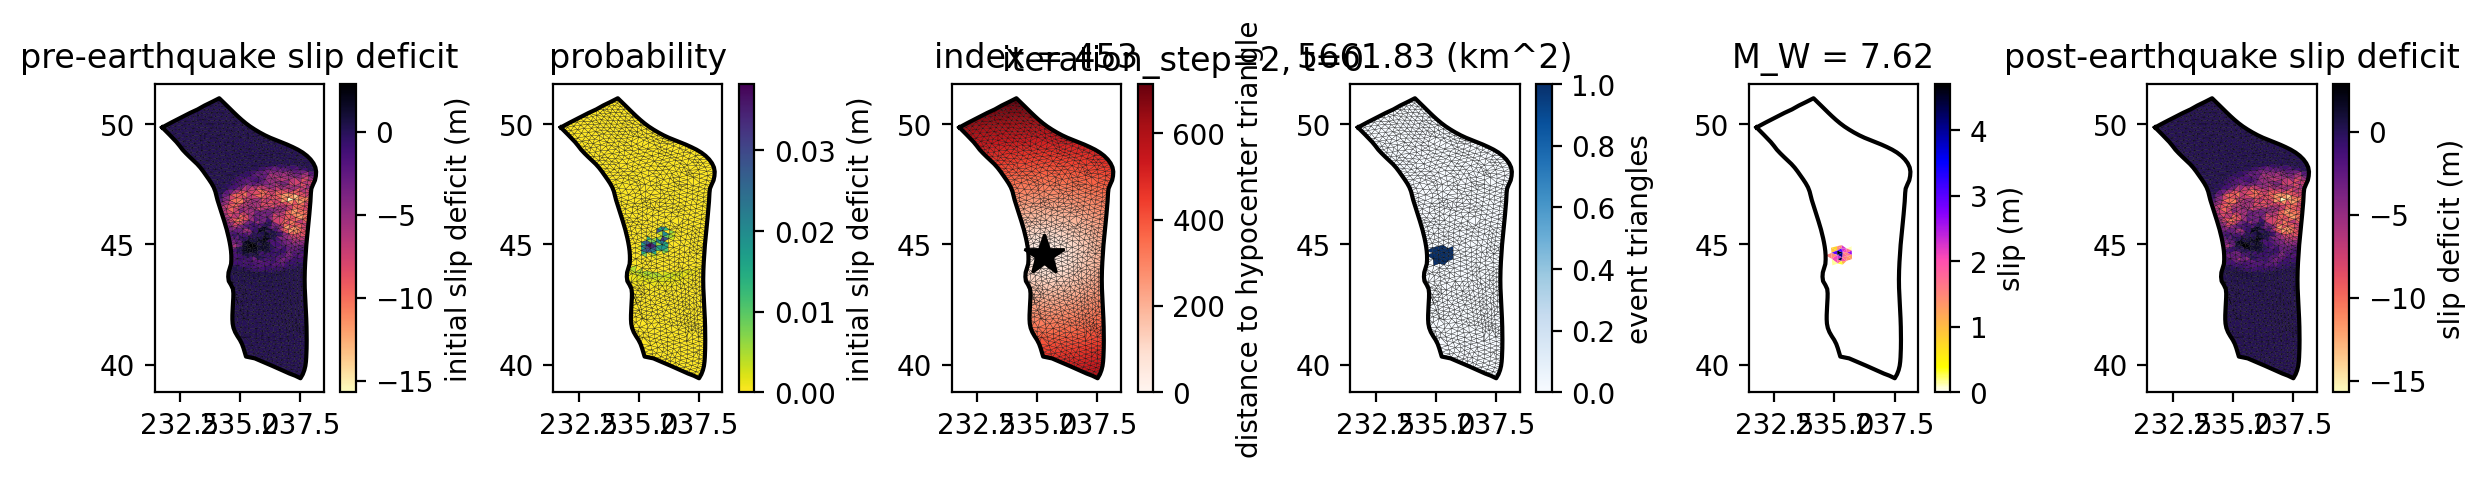

i=3
np.sum(pre_event_slip_deficit > 0)=1191
np.sum(np.isnan(temp_slip_deficit))=0
np.sum(np.isnan(probability))=0


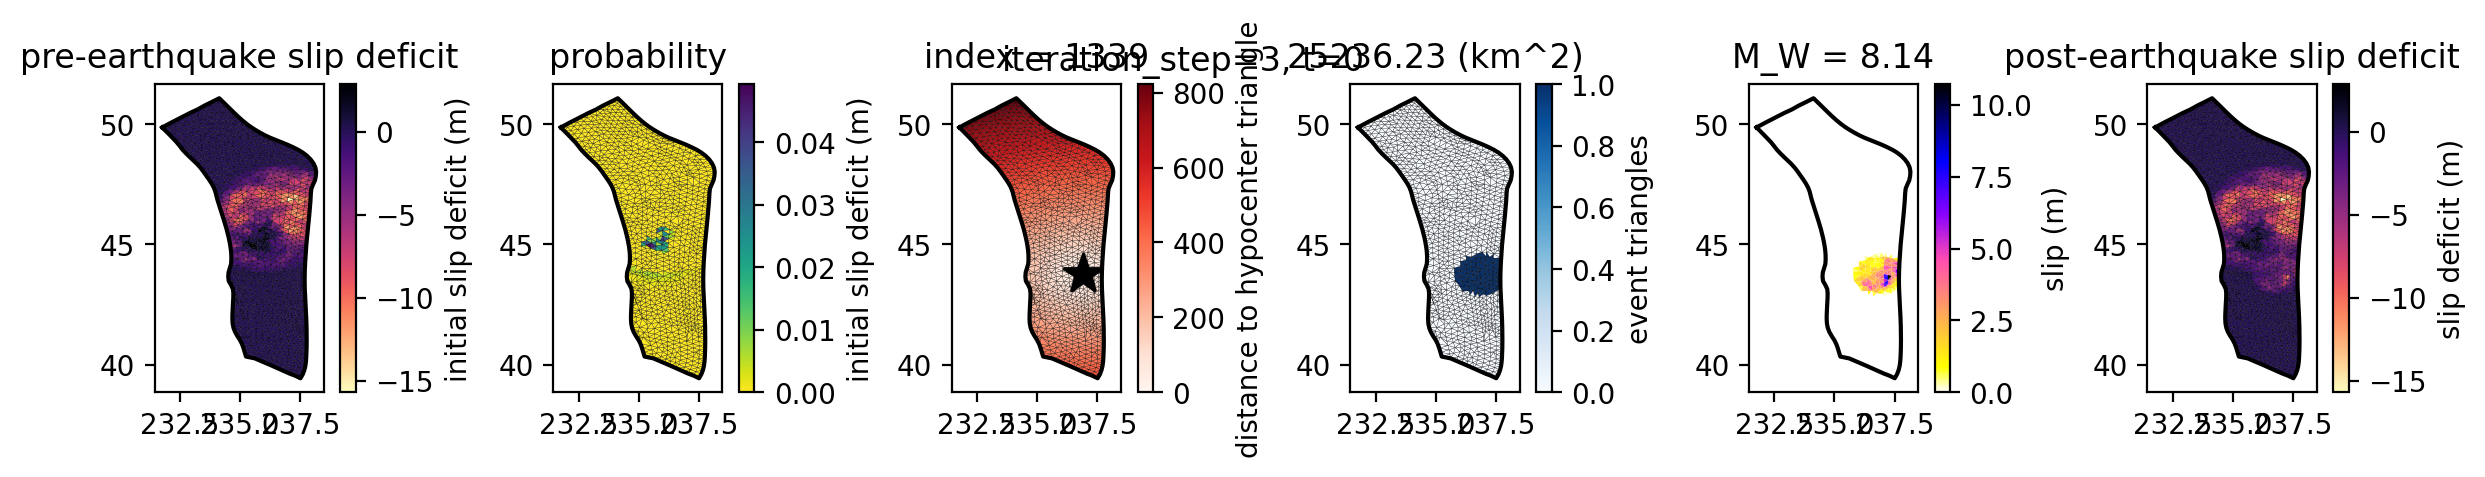

i=4
np.sum(pre_event_slip_deficit > 0)=1095
np.sum(np.isnan(temp_slip_deficit))=0
np.sum(np.isnan(probability))=0


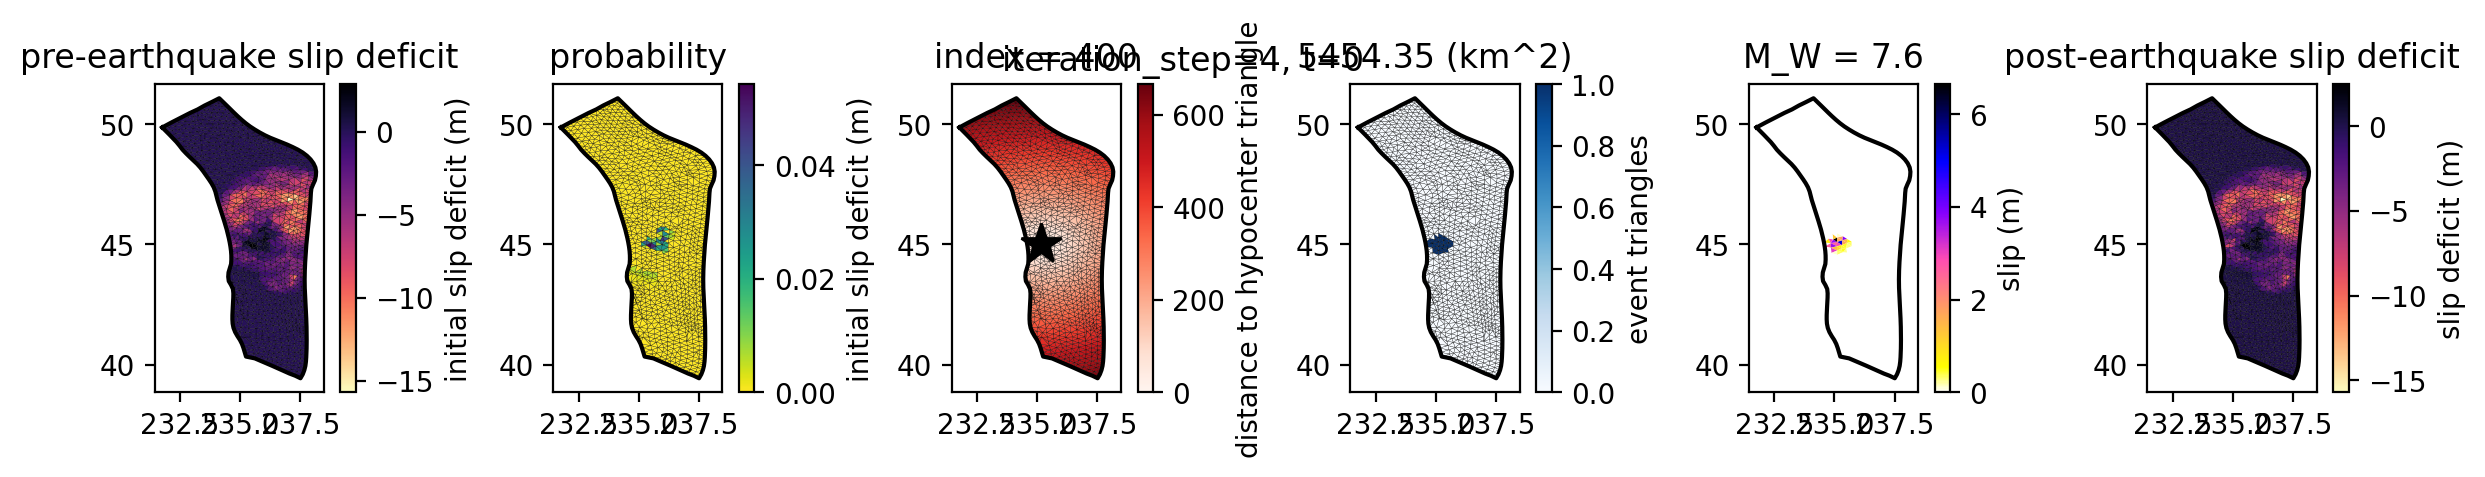

In [13]:
t = 0
pre_event_slip_deficit = initial_dip_slip_deficit
for i in range(5):
    print(f"{i=}")
    print(f"{np.sum(pre_event_slip_deficit > 0)=}")

    # Only go through the event generation process of there is positive slip deficit somewhere
    if np.sum(pre_event_slip_deficit > 0) > 0:
        location_probability = skies.get_location_probability(pre_event_slip_deficit, t)
        event = skies.create_event(meshes, location_probability)
        total_coseismic_slip += event.slip_all_elements
        post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements
        # print_event(event, meshes)
        skies.plot_event(
            event,
            meshes,
            pre_event_slip_deficit,
            location_probability,
            post_event_slip_deficit,
            t,
            i,
        )
        pre_event_slip_deficit = np.copy(post_event_slip_deficit)


In [14]:
# TODO: #10 Write up eigenvalue shape idea
# TODO: #11 Revisit probability calcuation with sigmoid.  We're generating occasional Nans
# TODO: #15 Write up theory for time probability
# TODO: #14 Code 1D time series example with: 1) loading, 2) coseismic jumps, 2) Omori like decay after earthquake

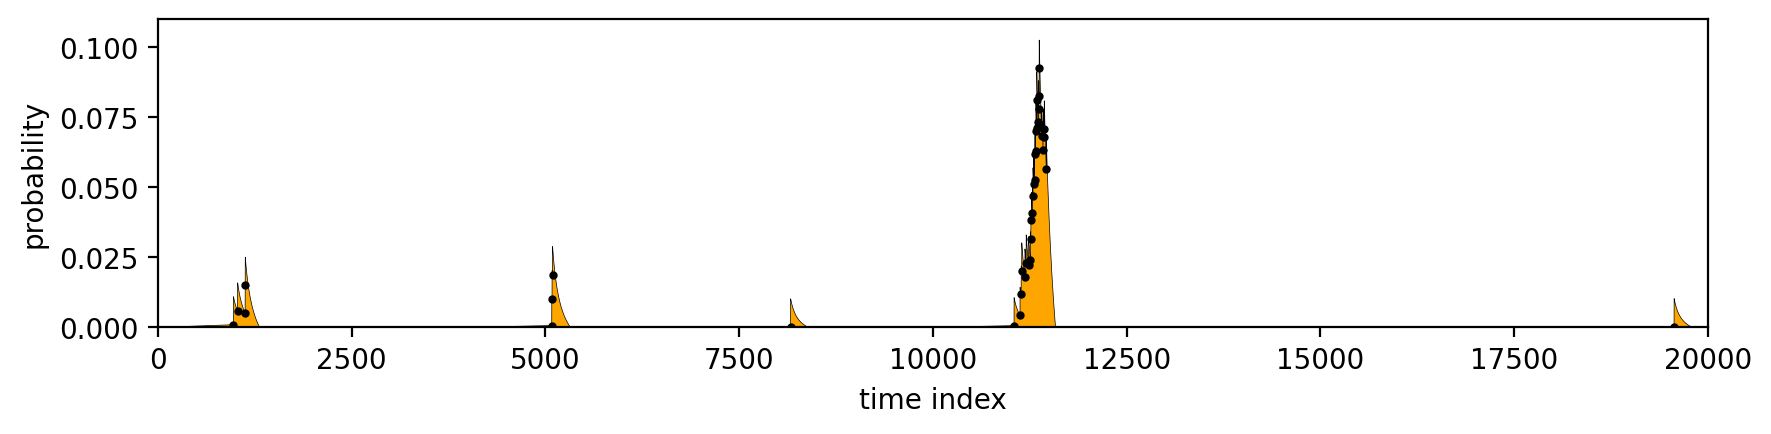

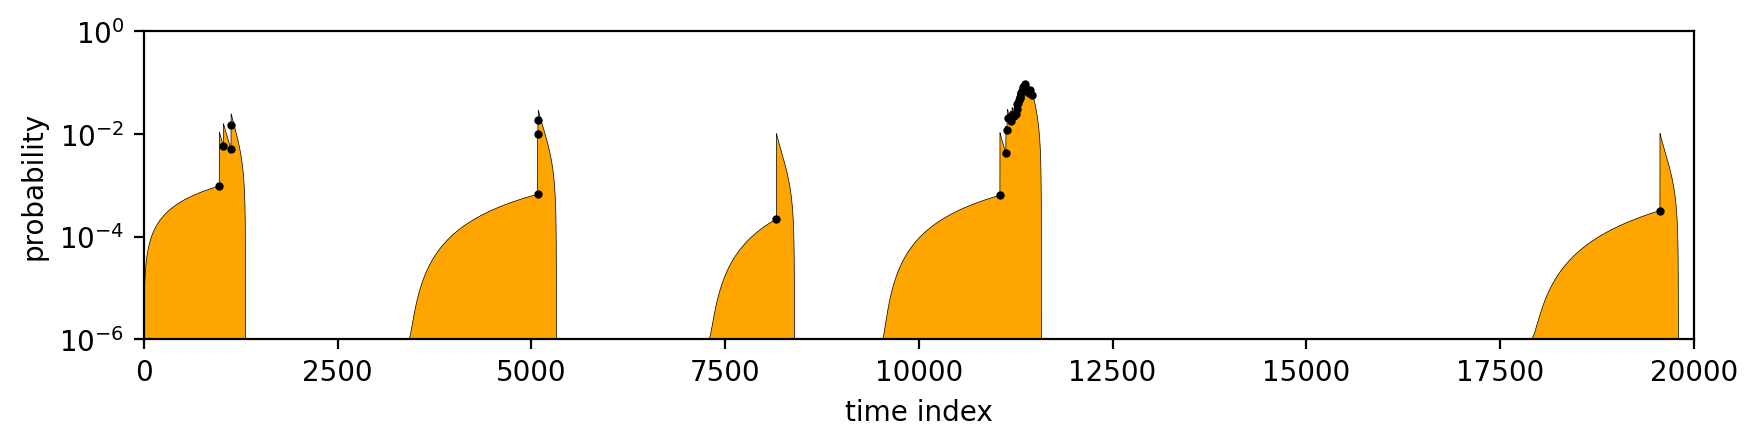

In [82]:
# 1D time series experiment
np.random.seed(0)


def get_omori_decay_probability(time_vector, time_of_earthquake, amplitude, decay_time):
    omori_decay_probability = amplitude / (
        1 + (1 / decay_time) * (time_vector - time_of_earthquake)
    )

    omori_decay_probability[time_vector < time_of_earthquake] = 0.0
    return omori_decay_probability


MM2M = 1e-3  # millimeters to meters
SECONDS_IN_A_YEAR = 60 * 60 * 24 * 365
DAYS_IN_A_YEAR = 365
n_years = 20000
time_vector = np.linspace(0, n_years, n_years * 1)
minimum_probability = 1e-6
time_probability = np.zeros_like(time_vector)
time_probability = minimum_probability * np.ones_like(time_vector)

loading_rate = 30.0  # (mm/yr)
earthquake_index_list = []
earthquake_magnitude_list = []
earthquake_probability_list = []

MINIMUM_EVENT_MOMENT_MAGNITUDE = 6.5
MAXIMUM_EVENT_MOMENT_MAGNITUDE = 9.0

amplitude = 0.01

for i in range(0, len(time_vector) - 1):
    time_probability_step = 0.000001
    event_trigger = np.random.choice(
        2, 1, p=[1 - time_probability[i], time_probability[i]]
    )
    if event_trigger == 1:

        n_earthquakes = 1
        b_value = -1.0
        minimum_magnitude = MINIMUM_EVENT_MOMENT_MAGNITUDE
        moment_magnitude = skies.get_gutenberg_richter_magnitudes(
            n_earthquakes, b_value, minimum_magnitude
        )
        if moment_magnitude > MAXIMUM_EVENT_MOMENT_MAGNITUDE:
            moment_magnitude = MAXIMUM_EVENT_MOMENT_MAGNITUDE
        # print(f"{i}, {time_vector[i]:0.3f},  earthquake occurs")
        earthquake_magnitude_list.append(moment_magnitude)
        earthquake_index_list.append(i)
        earthquake_probability_list.append(
            get_omori_decay_probability(
                time_vector, time_vector[i], amplitude, decay_time=100.0
            )
        )
        time_probability[i + 1] = (
            time_probability[i] + time_probability_step + amplitude
        )
    else:
        time_probability[i + 1] = time_probability[i] + time_probability_step

        for j in range(len(earthquake_index_list)):
            time_probability[i + 1] += 1.5 * (
                earthquake_probability_list[j][i + 1]
                - earthquake_probability_list[j][i]
            )

    # Catch probabilities less than zero
    if time_probability[i + 1] < minimum_probability:
        time_probability[i + 1] = minimum_probability

    # Catch probabilities greater than one
    if time_probability[i + 1] >= 1.0:
        break

# Non-log plot
plt.figure(figsize=(10, 2))
plt.plot(time_vector, time_probability, "-k", linewidth=0.25)
for i in range(len(earthquake_index_list)):
    plt.plot(
        time_vector[earthquake_index_list[i]],
        time_probability[earthquake_index_list[i]],
        ".k",
        markersize=4,
        linewidth=0.0,
    )
plt.fill(np.append(time_vector, 0), np.append(time_probability, minimum_probability), color="orange", alpha=1.0, edgecolor=None)
plt.xlabel("time index")
plt.ylabel("probability")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([0, 0.11])
plt.savefig("example_probability_time_series.pdf")
plt.savefig("example_probability_time_series.png", dpi=500)
plt.show()

# Semilogy plot
plt.figure(figsize=(10, 2))
plt.semilogy(time_vector, time_probability, "-k", linewidth=0.25)
for i in range(len(earthquake_index_list)):
    plt.plot(
        time_vector[earthquake_index_list[i]],
        time_probability[earthquake_index_list[i]],
        ".k",
        markersize=4,
        linewidth=0.0,
    )
plt.fill(np.append(time_vector, 0), np.append(time_probability, minimum_probability), color="orange", alpha=1.0, edgecolor=None)
plt.xlabel("time index")
plt.ylabel("probability")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([minimum_probability, 1])
plt.savefig("example_probability_time_series_semilogy.pdf")
plt.savefig("example_probability_time_series_semilogy.png", dpi=500)
plt.show()


In [51]:
np.append(time_vector, 0)

array([0.00000000e+00, 1.00005000e+00, 2.00010001e+00, ...,
       1.99989999e+04, 2.00000000e+04, 0.00000000e+00])

In [57]:
fill_shading_steps

array([6.5 , 5.79, 5.08, 4.37, 3.66, 2.95, 2.24, 1.53, 0.82, 0.11])